In [1]:
# %pip install pandas
# %pip install numpy matplotlib

In [2]:
# %pip install seaborn

In [3]:
# Define column names
column_names = [
    'duration', 'protocol_type', 'service', 'flag',
    'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class', 'difficulty'
]

In [4]:
import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# Load the training data
train_df = pd.read_csv(
    r"C:\Users\yasha\Downloads\nsl-kdd\KDDTrain+.txt",
    header=None,
    names=column_names
)

# Drop the 'difficulty' column
train_df.drop(['difficulty'], axis=1, inplace=True)

# Load the testing data
test_df = pd.read_csv(
    r"C:\Users\yasha\Downloads\nsl-kdd\KDDTest+.txt",
    header=None,
    names=column_names
)

# Drop the 'difficulty' column
test_df.drop(['difficulty'], axis=1, inplace=True)

# Print basic info
print("Training Data")
print(f"Shape: {train_df.shape}")
print(train_df.head())

print("\n--- Testing Data ---")
print(f"Shape: {test_df.shape}")
print(test_df.head())


Training Data
Shape: (125973, 42)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                  

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [6]:
train_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [7]:
train_df['class']

0          normal
1          normal
2         neptune
3          normal
4          normal
           ...   
125968    neptune
125969     normal
125970     normal
125971    neptune
125972     normal
Name: class, Length: 125973, dtype: object

In [8]:
train_df[['protocol_type','class']]

,protocol_type,class
0,tcp,normal
1,udp,normal
2,tcp,neptune
3,tcp,normal
4,tcp,normal
...,...,...
125968,tcp,neptune
125969,udp,normal
125970,tcp,normal
125971,tcp,neptune


In [9]:
train_df['class'].value_counts()

class
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [11]:
# Create a binary classification target
train_df['attack_binary'] = train_df['class'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['attack_binary']  = test_df['class'].apply(lambda x: 0 if x == 'normal' else 1)


C:\Users\yasha\AppData\Local\Temp\ipykernel_11132\3048207094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack_binary', data=train_df, palette='Set1')


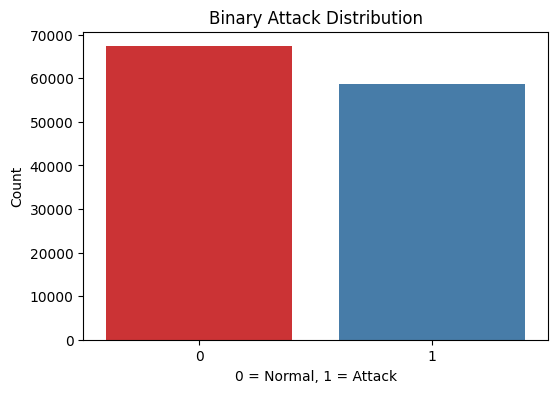

attack_binary
0    0.534583
1    0.465417
Name: proportion, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='attack_binary', data=train_df, palette='Set1')
plt.title('Binary Attack Distribution')
plt.xlabel('0 = Normal, 1 = Attack')
plt.ylabel('Count')
plt.show()

print(train_df['attack_binary'].value_counts(normalize=True))


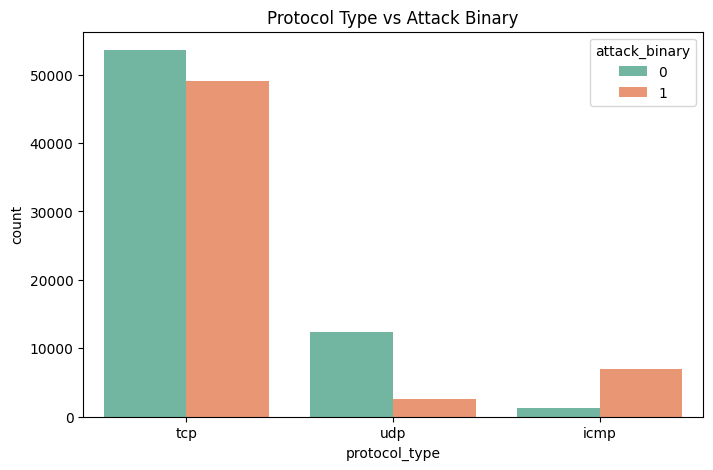

protocol_type
tcp     102689
udp      14993
icmp      8291
Name: count, dtype: int64

 protocol_type  attack_binary
icmp           0                 1309
               1                 6982
tcp            0                53600
               1                49089
udp            0                12434
               1                 2559
dtype: int64


In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='protocol_type', hue='attack_binary', data=train_df, palette='Set2')
plt.title('Protocol Type vs Attack Binary')
plt.show()

print(train_df['protocol_type'].value_counts())
print('\n',train_df.groupby(['protocol_type', 'attack_binary']).size())


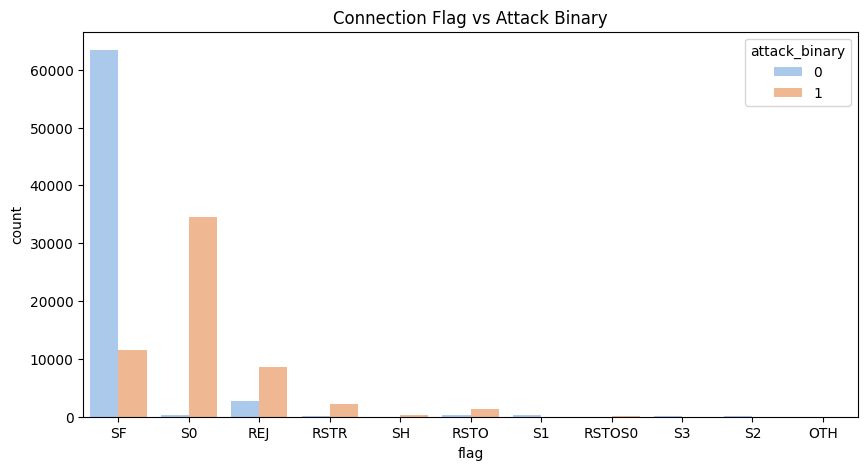

flag
SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: count, dtype: int64


In [39]:
plt.figure(figsize=(10,5))
sns.countplot(x='flag', hue='attack_binary', data=train_df, palette='pastel')
plt.title('Connection Flag vs Attack Binary')
plt.show()

print(train_df['flag'].value_counts())


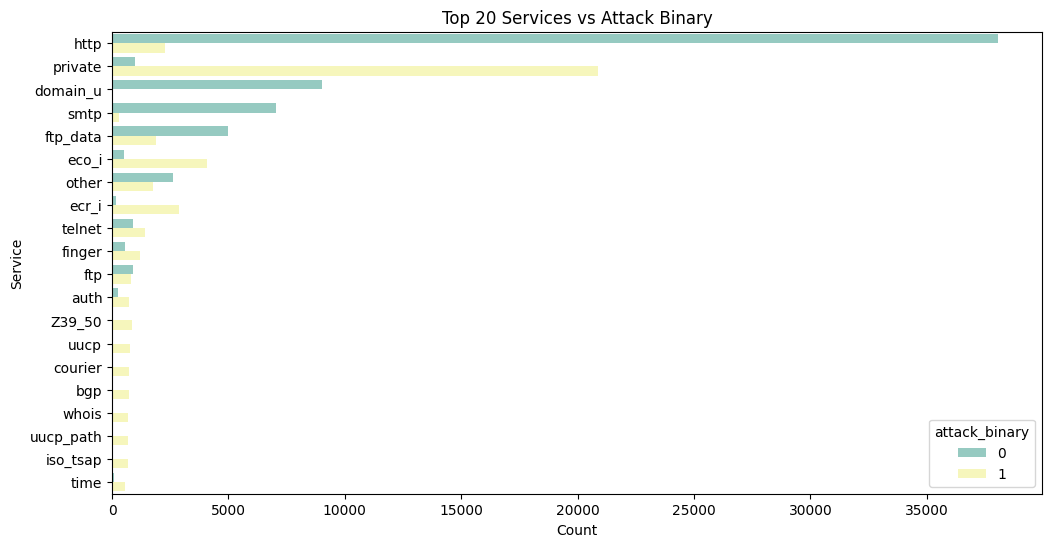

In [28]:
top_services = train_df['service'].value_counts().nlargest(20).index
plt.figure(figsize=(12,6))
sns.countplot(y='service', data=train_df[train_df['service'].isin(top_services)],
              order=top_services, hue='attack_binary', palette='Set3')
plt.title('Top 20 Services vs Attack Binary')
plt.xlabel('Count')
plt.ylabel('Service')
plt.show()


C:\Users\yasha\AppData\Local\Temp\ipykernel_11132\2067386840.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='class', data=attack_df, order=attack_df['class'].value_counts().index, palette='viridis')


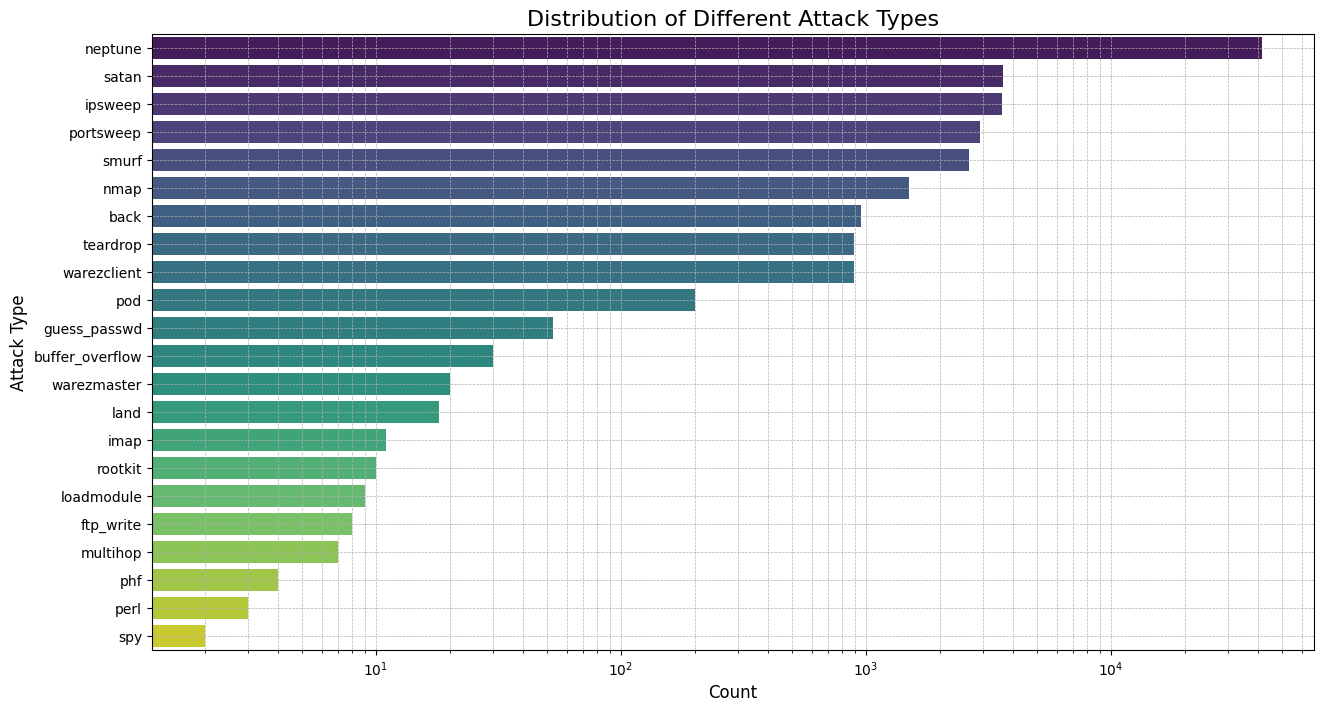

In [40]:
attack_df = train_df[train_df['attack_binary'] == 1]

plt.figure(figsize=(15, 8))
sns.countplot(y='class', data=attack_df, order=attack_df['class'].value_counts().index, palette='viridis')
plt.title("Distribution of Different Attack Types", fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Attack Type', fontsize=12)
plt.xscale('log')  # log scale for better visibility
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()